In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy.stats as stats
from scipy.stats import (
    chi2_contingency, ks_2samp, mannwhitneyu, ttest_ind)
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import (
    auc, classification_report, confusion_matrix, roc_auc_score, mean_squared_error, 
    roc_curve, r2_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
import statsmodels.stats.multitest as smm



In [2]:
N_number = 14138621  
rng = np.random.default_rng(seed = N_number)  # Set seed for reproducibility

In [3]:
df = pd.read_csv('rmpCapstoneNum.csv')
df2 = pd.read_csv('rmpCapstoneQual.csv')
df3 = pd.read_csv('rmpCapstoneTags.csv')

In [4]:
# Data Cleaning

def fix_df(a):
    # Save the current column names as a new row
    column_names_as_row = list(a.columns)
    
    # Shift all rows down by 1, adding an empty final row
    a = a.reindex(range(len(a) + 1)).shift(1, axis=0)
    
    # Add the column names as the first row
    a.iloc[0] = column_names_as_row
    
    # Reset column names to default or placeholders
    a.columns = [f"Col{i+1}" for i in range(len(column_names_as_row))]  

    return a


cap_num = fix_df(df)
cap_qual = fix_df(df2)
cap_tags = fix_df(df3)
    

/var/folders/lr/1nb_vllj419bncfmzmb9hkzw0000gn/T/ipykernel_7237/236449196.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  a.iloc[0] = column_names_as_row
/var/folders/lr/1nb_vllj419bncfmzmb9hkzw0000gn/T/ipykernel_7237/236449196.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  a.iloc[0] = column_names_as_row
/var/folders/lr/1nb_vllj419bncfmzmb9hkzw0000gn/T/ipykernel_7237/236449196.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  a.iloc[0] = column_nam

In [5]:
cap_num.columns = [
    "Average Rating",
    "Average Difficulty",
    "Number of Ratings",
    "Received a Pepper?",
    "Proportion Would Take Again",
    "Number of Online Ratings",
    "Male?",
    "Female?"
]

cap_qual.columns = [
    "Major",
    "University",
    "US State"
]

cap_tags.columns = [
    "Tough grader",
    "Good feedback",
    "Respected",
    "Lots to read",
    "Participation matters",
    "Don’t skip class or you will not pass",
    "Lots of homework",
    "Inspirational",
    "Pop quizzes!",
    "Accessible",
    "So many papers",
    "Clear grading",
    "Hilarious",
    "Test heavy",
    "Graded by few things",
    "Amazing lectures",
    "Caring",
    "Extra credit",
    "Group projects",
    "Lecture heavy"
]


In [6]:
merged_df = cap_num.merge(cap_qual, left_index=True, right_index=True)
teacher_df = merged_df.merge(cap_tags, left_index=True, right_index=True)
teacher_df["Number of Ratings"] = pd.to_numeric(teacher_df["Number of Ratings"], errors="coerce")
percentiles = teacher_df['Number of Ratings'].quantile([0.25, 0.5, 0.75])
print(percentiles)

0.25    1.0
0.50    3.0
0.75    6.0
Name: Number of Ratings, dtype: float64


In [7]:
for col in teacher_df.columns:
    try:
        teacher_df[col] = teacher_df[col].astype(float)  # Attempt to convert column to float
    except ValueError:
        pass  #  skip the column if it can't be converted


In [8]:
# Compute the global mean
global_mean = teacher_df["Average Rating"].mean()

# Test different k values
k_values = [1, 2, 3, 4, 5, 6]
adjusted_ratings = {}

for k in k_values:
    # Compute adjusted ratings directly without adding columns
    adjusted_rating = (
        (teacher_df["Average Rating"] * teacher_df["Number of Ratings"]) + (k * global_mean)
    ) / (teacher_df["Number of Ratings"] + k)
    adjusted_ratings[k] = adjusted_rating.mean()

# Compare average adjusted ratings for each k
print("Average Adjusted Ratings for Different k:")
print(adjusted_ratings)


Average Adjusted Ratings for Different k:
{1: 3.8131378362725132, 2: 3.814604569829778, 3: 3.815163803213677, 4: 3.8153718674418187, 5: 3.815415090185037, 6: 3.8153727881110306}


In [9]:
# Set k
k = 3

# Calculate Adjusted Rating
teacher_df["Adjusted Rating"] = (
    (teacher_df["Average Rating"] * teacher_df["Number of Ratings"]) + (k * global_mean)
) / (teacher_df["Number of Ratings"] + k)

# Calculate Adjusted Difficulty Rating
teacher_df["Adjusted Difficulty"] = (
    (teacher_df["Average Difficulty"] * teacher_df["Number of Ratings"]) + (k * global_mean)
) / (teacher_df["Number of Ratings"] + k)


In [10]:
#1 and 3. 

# Filter data to include only entries with Adjusted Ratings
mf_df = teacher_df.dropna(subset=['Adjusted Rating'])

# Male and Female Adjusted Ratings
male_ratings = mf_df[mf_df["Male?"] == 1]["Adjusted Rating"]
female_ratings = mf_df[mf_df["Female?"] == 1]["Adjusted Rating"]

# Perform Independent T-Test 
t_stat, p_value = ttest_ind(male_ratings, female_ratings, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Calculate effect size (Cohen's d)
def cohens_d(group1, group2):
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.var(group1, ddof=1) + np.var(group2, ddof=1)) / 2)
    return mean_diff / pooled_std

effect_size = cohens_d(male_ratings, female_ratings)
print(f"Cohen's d (Effect Size): {effect_size}")

# Bootstrap Confidence Interval for Cohen's d with RNG
def bootstrap_effect_size(data1, data2, n_bootstrap=10000, alpha=0.005, seed=None):
    rng = np.random.default_rng(seed)  
    bootstrapped_effects = []
    combined = np.concatenate([data1, data2])  # Combine both datasets

    for _ in range(n_bootstrap):
        # Resample with replacement using RNG
        sample1 = rng.choice(data1, size=len(data1), replace=True)
        sample2 = rng.choice(data2, size=len(data2), replace=True)
        
        # Compute effect size for resampled data
        bootstrapped_effects.append(cohens_d(sample1, sample2))
    
    # Compute confidence intervals from bootstrapped effect sizes
    lower = np.percentile(bootstrapped_effects, alpha / 2 * 100)
    upper = np.percentile(bootstrapped_effects, (1 - alpha / 2) * 100)
    return lower, upper

# Compute 95% Confidence Interval for Cohen's d with a fixed RNG seed
ci_lower, ci_upper = bootstrap_effect_size(male_ratings, female_ratings, seed=42)
print(f"95% Confidence Interval for Cohen's d: ({ci_lower}, {ci_upper})")




T-statistic: 6.905746911715357, P-value: 5.047120676654414e-12
Cohen's d (Effect Size): 0.058169160625755806
95% Confidence Interval for Cohen's d: (0.03465459869804977, 0.08258697264948449)


In [11]:
#2 and 3. 

# Perform KS test
ks_stat, p_value = ks_2samp(male_ratings, female_ratings)
print(f"KS Statistic: {ks_stat}")
print(f"KS p-value: {p_value}")

# Bootstrap Confidence Interval for KS Statistic
def ks_bootstrap_ci(data1, data2, n_bootstrap=10000, alpha=0.005):
    
    # Store bootstrapped KS statistics
    ks_statistics = []
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        sample1 = rng.choice(data1, size=len(data1), replace=True)
        sample2 = rng.choice(data2, size=len(data2), replace=True)
        
        # Compute KS statistic for resampled data
        ks_stat_bootstrap, _ = ks_2samp(sample1, sample2)
        ks_statistics.append(ks_stat_bootstrap)
    
    # Compute confidence intervals
    lower = np.percentile(ks_statistics, alpha / 2 * 100)
    upper = np.percentile(ks_statistics, (1 - alpha / 2) * 100)
    
    return lower, upper

# Compute 95% CI for KS statistic
ks_ci_lower, ks_ci_upper = ks_bootstrap_ci(male_ratings, female_ratings)
print(f"95% Confidence Interval for KS Statistic: ({ks_ci_lower}, {ks_ci_upper})")

# Cohen's f² for effect size
male_variance = np.var(male_ratings, ddof=1)  # Variance of male ratings
female_variance = np.var(female_ratings, ddof=1)  # Variance of female ratings
cohens_f2 = (male_variance - female_variance) / max(male_variance, female_variance)
print(cohens_f2)


KS Statistic: 0.023992359424783283
KS p-value: 1.7375996171987348e-07
95% Confidence Interval for KS Statistic: (0.015806142388603617, 0.03621650578730551)
-0.04405817555115238


In [12]:
#4. 
# Subset relevant columns
gendered_tags_df = teacher_df[[
    'Male?', 'Female?',  
    "Tough grader",
    "Good feedback",
    "Respected",
    "Lots to read",
    "Participation matters",
    "Don’t skip class or you will not pass",
    "Lots of homework",
    "Inspirational",
    "Pop quizzes!",
    "Accessible",
    "So many papers",
    "Clear grading",
    "Hilarious",
    "Test heavy",
    "Graded by few things",
    "Amazing lectures",
    "Caring",
    "Extra credit",
    "Group projects",
    "Lecture heavy"
]].dropna()

# Initialize results list
permutation_results = []

# Loop through each tag
for tag in gendered_tags_df.columns[2:]:  # Skip 'Male?' and 'Female?'
    target_tag = tag

    # Observed difference in proportions
    observed_diff = (
        gendered_tags_df.loc[gendered_tags_df['Male?'] == 1, target_tag].mean() -
        gendered_tags_df.loc[gendered_tags_df['Female?'] == 1, target_tag].mean()
    )

    # Permutation test
    num_permutations = 10000  # Number of permutations
    perm_diffs = []

    for _ in range(num_permutations):
        # Shuffle gender labels using RNG
        shuffled_gender = rng.permutation(gendered_tags_df['Male?'].values)
        
        # Assign shuffled genders back into a temporary dataframe
        shuffled_df = gendered_tags_df.copy()
        shuffled_df['Shuffled Male?'] = shuffled_gender

        # Compute the permuted difference in means
        perm_diff = (
            shuffled_df.loc[shuffled_df['Shuffled Male?'] == 1, target_tag].mean() -
            shuffled_df.loc[shuffled_df['Shuffled Male?'] == 0, target_tag].mean()
        )
        perm_diffs.append(perm_diff)

    # Calculate p-value
    perm_diffs = np.array(perm_diffs)
    p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
    permutation_results.append({"Tag": target_tag, "Observed Diff": observed_diff, "P-value": p_value})

# Convert results to DataFrame
permutation_results_df = pd.DataFrame(permutation_results)

# Sort by p-value
permutation_results_df = permutation_results_df.sort_values(by="P-value")

# Display results
print(permutation_results_df)


                                      Tag  Observed Diff  P-value
9                              Accessible       0.074054   0.0000
15                       Amazing lectures       0.227987   0.0000
14                   Graded by few things       0.056169   0.0000
13                             Test heavy       0.045076   0.0000
12                              Hilarious       0.413570   0.0000
10                         So many papers      -0.021811   0.0000
18                         Group projects      -0.040979   0.0000
19                          Lecture heavy       0.134354   0.0000
4                   Participation matters      -0.044814   0.0000
2                               Respected       0.241383   0.0000
7                           Inspirational       0.106916   0.0000
16                                 Caring      -0.060347   0.0001
8                            Pop quizzes!       0.023525   0.0002
17                           Extra credit      -0.033097   0.0042
5   Don’t 

In [13]:
#5 and 6. 

# Filter data to include only entries with Adjusted Ratings
mf_df = teacher_df.dropna(subset=['Adjusted Difficulty'])

# Male and Female Adjusted Ratings
male_ratings = mf_df[mf_df["Male?"] == 1]["Adjusted Difficulty"]
female_ratings = mf_df[mf_df["Female?"] == 1]["Adjusted Difficulty"]

# Independent t-test for differences in means
t_stat, p_value = ttest_ind(male_ratings, female_ratings, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Calculate effect size (Cohen's d)
def cohens_d(group1, group2):
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.var(group1, ddof=1) + np.var(group2, ddof=1)) / 2)
    return mean_diff / pooled_std

effect_size = cohens_d(male_ratings, female_ratings)
print(f"Cohen's d (Effect Size): {effect_size}")

# Bootstrap Confidence Interval for Cohen's d with RNG
def bootstrap_effect_size(data1, data2, n_bootstrap=10000, alpha=0.005, seed=None):
    bootstrapped_effects = []
    combined = np.concatenate([data1, data2])  # Combine both datasets

    for _ in range(n_bootstrap):
        # Resample with replacement using RNG
        sample1 = rng.choice(data1, size=len(data1), replace=True)
        sample2 = rng.choice(data2, size=len(data2), replace=True)
        
        # Compute effect size for resampled data
        bootstrapped_effects.append(cohens_d(sample1, sample2))
    
    # Compute confidence intervals from bootstrapped effect sizes
    lower = np.percentile(bootstrapped_effects, alpha / 2 * 100)
    upper = np.percentile(bootstrapped_effects, (1 - alpha / 2) * 100)
    return lower, upper

# Compute 95% Confidence Interval for Cohen's d with a fixed RNG seed
ci_lower, ci_upper = bootstrap_effect_size(male_ratings, female_ratings, seed=42)
print(f"95% Confidence Interval for Cohen's d: ({ci_lower}, {ci_upper})")




T-statistic: -3.033565593403127, P-value: 0.0024179225640862385
Cohen's d (Effect Size): -0.025531988462675594
95% Confidence Interval for Cohen's d: (-0.0483483509568516, -0.0029404385550540584)


In [14]:
#7 

df_for_num = teacher_df[["Adjusted Rating", "Adjusted Difficulty", "Number of Ratings", "Received a Pepper?", "Proportion Would Take Again", "Number of Online Ratings", "Male?", "Female?"]].dropna()

# Split features and target
X = df_for_num.drop(columns=["Adjusted Rating"])  # Predictors
y = df_for_num["Adjusted Rating"]  # Target variable

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Build the regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Make predictions
y_pred = model.predict(X_scaled)

# Evaluate the model
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"R^2: {r2}")
print(f"RMSE: {rmse}")

# Identify the most predictive factors
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("Most Predictive Factors:")
print(coefficients)


R^2: 0.8067756050248297
RMSE: 0.29701953800789044
Most Predictive Factors:
                       Feature  Coefficient
3  Proportion Would Take Again     0.486324
0          Adjusted Difficulty    -0.127132
2           Received a Pepper?     0.085066
5                        Male?     0.019501
6                      Female?     0.009526
4     Number of Online Ratings     0.000529
1            Number of Ratings     0.000384


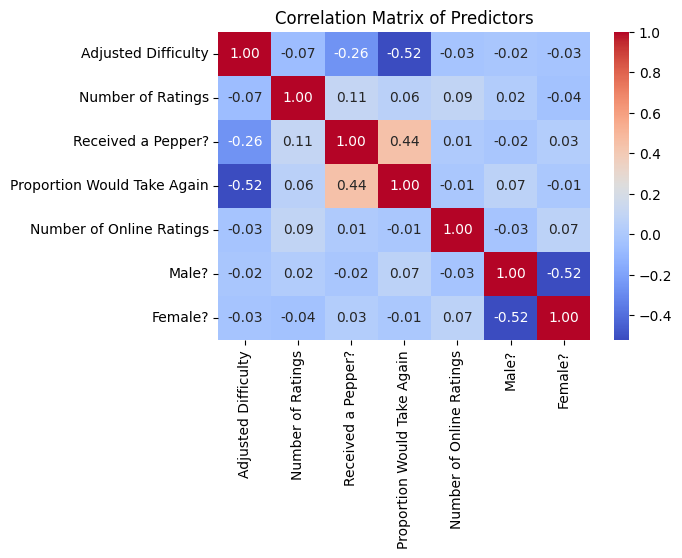

Series([], dtype: float64)


In [15]:
# Compute correlation matrix
correlation_matrix = X.corr()

# Visualize the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Predictors")
plt.show()

# Identify highly correlated pairs
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs != 1]  # Exclude self-correlation
print(high_corr_pairs[high_corr_pairs > 0.5])

In [16]:
#8 

df_for_tags = teacher_df[["Adjusted Rating", "Tough grader",
    "Good feedback",
    "Respected",
    "Lots to read",
    "Participation matters",
    "Don’t skip class or you will not pass",
    "Lots of homework",
    "Inspirational",
    "Pop quizzes!",
    "Accessible",
    "So many papers",
    "Clear grading",
    "Hilarious",
    "Test heavy",
    "Graded by few things",
    "Amazing lectures",
    "Caring",
    "Extra credit",
    "Group projects",
    "Lecture heavy"]].dropna()

# Split features and target
X = df_for_tags.drop(columns=["Adjusted Rating"])  # Predictors
y = df_for_tags["Adjusted Rating"]  # Target variable

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Build the regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Make predictions
y_pred = model.predict(X_scaled)

# Evaluate the model
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"R^2: {r2}")
print(f"RMSE: {rmse}")

# Identify the most predictive factors
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("Most Predictive Factors:")
print(coefficients)


R^2: 0.34493224419447466
RMSE: 0.45169987163724057
Most Predictive Factors:
                                  Feature  Coefficient
0                            Tough grader    -0.195259
1                           Good feedback     0.104257
16                                 Caring     0.080646
19                          Lecture heavy    -0.071186
15                       Amazing lectures     0.061307
11                          Clear grading     0.048025
18                         Group projects    -0.046577
10                         So many papers    -0.045277
6                        Lots of homework    -0.041333
14                   Graded by few things    -0.031857
12                              Hilarious     0.028862
5   Don’t skip class or you will not pass     0.016663
2                               Respected     0.012623
3                            Lots to read    -0.009830
8                            Pop quizzes!     0.007711
13                             Test heavy   

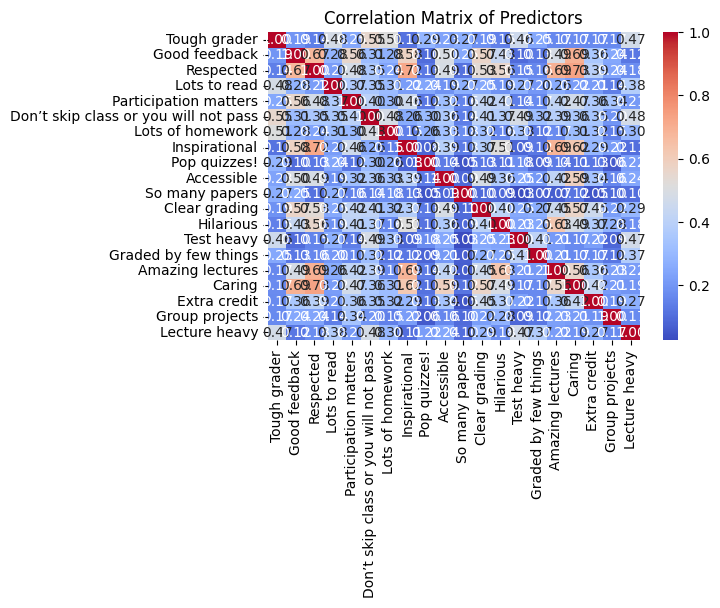

Respected         Caring              0.730799
Caring            Respected           0.730799
Respected         Inspirational       0.720787
Inspirational     Respected           0.720787
Respected         Amazing lectures    0.694935
Amazing lectures  Respected           0.694935
Caring            Good feedback       0.693351
Good feedback     Caring              0.693351
Inspirational     Amazing lectures    0.685896
Amazing lectures  Inspirational       0.685896
Good feedback     Respected           0.674958
Respected         Good feedback       0.674958
Amazing lectures  Hilarious           0.627966
Hilarious         Amazing lectures    0.627966
Inspirational     Caring              0.621096
Caring            Inspirational       0.621096
dtype: float64


In [17]:
# Compute correlation matrix
correlation_matrix = X.corr()

# Visualize the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Predictors")
plt.show()

# Identify highly correlated pairs
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs != 1]  # Exclude self-correlation
print(high_corr_pairs[high_corr_pairs > 0.60])

In [18]:
# Fit Ridge Regression model
ridge_model = Ridge(alpha=0.01)  # Regularization strength
ridge_model.fit(X, y)

# Get coefficients
ridge_coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": ridge_model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)
print(ridge_coefficients)

                                  Feature  Coefficient
0                            Tough grader    -0.088614
10                         So many papers    -0.072977
14                   Graded by few things    -0.056549
19                          Lecture heavy    -0.053657
18                         Group projects    -0.043562
1                           Good feedback     0.037911
16                                 Caring     0.033725
15                       Amazing lectures     0.030240
11                          Clear grading     0.029534
6                        Lots of homework    -0.020608
12                              Hilarious     0.012447
8                            Pop quizzes!     0.008570
5   Don’t skip class or you will not pass     0.008314
3                            Lots to read    -0.005432
2                               Respected     0.005329
13                             Test heavy     0.004447
9                              Accessible    -0.001913
17        

In [19]:
# Predictions on the dataset
y_pred_ridge = ridge_model.predict(X_scaled)

# Calculate R^2 and RMSE
r2 = r2_score(y, y_pred_ridge)
rmse = np.sqrt(mean_squared_error(y, y_pred_ridge))

print(f"R^2: {r2}")
print(f"RMSE: {rmse}")


R^2: 0.24571659726816952
RMSE: 0.484701240853308


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Lasso Regression with multiple alphas
alphas = np.logspace(-4, 1, 100)  # Range of alpha values
lasso_train_mse = []
lasso_val_mse = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, max_iter=10000)
    lasso_model.fit(X_train_scaled, y_train)
    
    # Predict on training and validation data
    y_train_pred = lasso_model.predict(X_train_scaled)
    y_val_pred = lasso_model.predict(X_val_scaled)
    
    # Calculate MSE
    lasso_train_mse.append(mean_squared_error(y_train, y_train_pred))
    lasso_val_mse.append(mean_squared_error(y_val, y_val_pred))

# Find the best alpha 
best_alpha = alphas[np.argmin(lasso_val_mse)]

# Train final Lasso model
final_lasso = Lasso(alpha=best_alpha, max_iter=10000)
final_lasso.fit(X_train_scaled, y_train)

# Predict on validation data
y_val_pred = final_lasso.predict(X_val_scaled)

# Evaluate
lasso_r2 = final_lasso.score(X_val_scaled, y_val)
lasso_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Lasso R^2: {lasso_r2}")
print(f"Lasso RMSE: {lasso_rmse}")


# Extract feature names and coefficients
lasso_coefs = final_lasso.coef_
coefficients_df = pd.DataFrame({
    "Feature": X.columns,  # Feature names from the original dataset
    "Coefficient": lasso_coefs
}).sort_values(by="Coefficient", key=abs, ascending=False)  # Sort by absolute value of coefficients

# Display coefficients
print("Lasso Coefficients:")
print(coefficients_df)


Lasso R^2: 0.3461795438051425
Lasso RMSE: 0.44039036122164843
Lasso Coefficients:
                                  Feature  Coefficient
0                            Tough grader    -0.194635
1                           Good feedback     0.107181
16                                 Caring     0.075683
19                          Lecture heavy    -0.064249
15                       Amazing lectures     0.062883
11                          Clear grading     0.048245
18                         Group projects    -0.045195
10                         So many papers    -0.042930
6                        Lots of homework    -0.034569
14                   Graded by few things    -0.031749
12                              Hilarious     0.024119
3                            Lots to read    -0.015696
5   Don’t skip class or you will not pass     0.012236
2                               Respected     0.010272
8                            Pop quizzes!     0.008660
13                             Test he

In [21]:
#9 

df_for_tags_diff = teacher_df[["Adjusted Difficulty", "Tough grader",
    "Good feedback",
    "Respected",
    "Lots to read",
    "Participation matters",
    "Don’t skip class or you will not pass",
    "Lots of homework",
    "Inspirational",
    "Pop quizzes!",
    "Accessible",
    "So many papers",
    "Clear grading",
    "Hilarious",
    "Test heavy",
    "Graded by few things",
    "Amazing lectures",
    "Caring",
    "Extra credit",
    "Group projects",
    "Lecture heavy"]].dropna()

# Split features and target
X = df_for_tags_diff.drop(columns=["Adjusted Difficulty"])  # Predictors
y = df_for_tags_diff["Adjusted Difficulty"]  # Target variable

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Build the regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Make predictions
y_pred = model.predict(X_scaled)

# Evaluate the model
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"R^2: {r2}")
print(f"RMSE: {rmse}")

# Identify the most predictive factors
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("Most Predictive Factors:")
print(coefficients)


R^2: 0.2650239427950243
RMSE: 0.4342835885536422
Most Predictive Factors:
                                  Feature  Coefficient
0                            Tough grader     0.182464
16                                 Caring    -0.105187
11                          Clear grading    -0.085912
9                              Accessible     0.060772
14                   Graded by few things    -0.039171
12                              Hilarious    -0.038715
1                           Good feedback    -0.029008
17                           Extra credit    -0.027492
4                   Participation matters    -0.026723
13                             Test heavy     0.025881
8                            Pop quizzes!    -0.023413
19                          Lecture heavy    -0.018966
7                           Inspirational    -0.017432
5   Don’t skip class or you will not pass     0.016491
10                         So many papers     0.009788
2                               Respected     

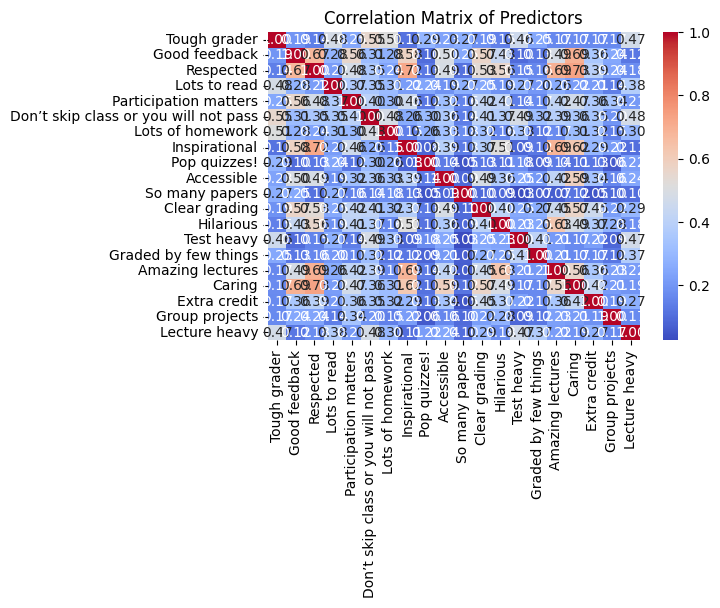

Respected         Caring              0.730799
Caring            Respected           0.730799
Respected         Inspirational       0.720787
Inspirational     Respected           0.720787
Respected         Amazing lectures    0.694935
Amazing lectures  Respected           0.694935
Caring            Good feedback       0.693351
Good feedback     Caring              0.693351
Inspirational     Amazing lectures    0.685896
Amazing lectures  Inspirational       0.685896
Good feedback     Respected           0.674958
Respected         Good feedback       0.674958
Amazing lectures  Hilarious           0.627966
Hilarious         Amazing lectures    0.627966
Inspirational     Caring              0.621096
Caring            Inspirational       0.621096
dtype: float64


In [22]:
# Compute correlation matrix
correlation_matrix = X.corr()

# Visualize the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Predictors")
plt.show()

# Identify highly correlated pairs
high_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs != 1]  # Exclude self-correlation
print(high_corr_pairs[high_corr_pairs > 0.60])

In [23]:
# Fit Ridge Regression model
ridge_model = Ridge(alpha=0.01)  # Regularization strength
ridge_model.fit(X, y)

# Get coefficients
ridge_coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": ridge_model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)
print(ridge_coefficients)


                                  Feature  Coefficient
0                            Tough grader     0.082807
14                   Graded by few things    -0.069532
11                          Clear grading    -0.052834
9                              Accessible     0.052172
16                                 Caring    -0.043988
13                             Test heavy     0.033076
8                            Pop quizzes!    -0.026021
12                              Hilarious    -0.016696
10                         So many papers     0.015776
17                           Extra credit    -0.014731
19                          Lecture heavy    -0.014295
4                   Participation matters    -0.013739
1                           Good feedback    -0.010548
7                           Inspirational    -0.009690
5   Don’t skip class or you will not pass     0.008228
2                               Respected     0.002899
18                         Group projects    -0.002618
6         

In [24]:
# Predictions on the dataset
y_pred_ridge = ridge_model.predict(X_scaled)

# Calculate R^2 and RMSE
r2 = r2_score(y, y_pred_ridge)
rmse = np.sqrt(mean_squared_error(y, y_pred_ridge))

print(f"R^2: {r2}")
print(f"RMSE: {rmse}")

R^2: 0.1817661012842703
RMSE: 0.458221598476402


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Lasso Regression with multiple alphas
alphas = np.logspace(-4, 1, 100)  # Range of alpha values
lasso_train_mse = []
lasso_val_mse = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, max_iter=10000)
    lasso_model.fit(X_train_scaled, y_train)
    
    # Predict on training and validation data
    y_train_pred = lasso_model.predict(X_train_scaled)
    y_val_pred = lasso_model.predict(X_val_scaled)
    
    # Calculate MSE
    lasso_train_mse.append(mean_squared_error(y_train, y_train_pred))
    lasso_val_mse.append(mean_squared_error(y_val, y_val_pred))

# Find the best alpha (minimum validation MSE)
best_alpha = alphas[np.argmin(lasso_val_mse)]

# Train final Lasso model
final_lasso = Lasso(alpha=best_alpha, max_iter=10000)
final_lasso.fit(X_train_scaled, y_train)

# Predict on validation data
y_val_pred = final_lasso.predict(X_val_scaled)

# Evaluate
lasso_r2 = final_lasso.score(X_val_scaled, y_val)
lasso_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Lasso R^2: {lasso_r2}")
print(f"Lasso RMSE: {lasso_rmse}")


# Extract feature names and coefficients
lasso_coefs = final_lasso.coef_
coefficients_df = pd.DataFrame({
    "Feature": X.columns,  # Feature names from the original dataset
    "Coefficient": lasso_coefs
}).sort_values(by="Coefficient", key=abs, ascending=False)  # Sort by absolute value of coefficients

# Display coefficients
print("Lasso Coefficients:")
print(coefficients_df)


Lasso R^2: 0.27234457317979877
Lasso RMSE: 0.43064325563400124
Lasso Coefficients:
                                  Feature  Coefficient
0                            Tough grader     0.182851
16                                 Caring    -0.103951
11                          Clear grading    -0.087452
9                              Accessible     0.058440
14                   Graded by few things    -0.036469
12                              Hilarious    -0.033306
1                           Good feedback    -0.032360
4                   Participation matters    -0.027897
13                             Test heavy     0.025310
8                            Pop quizzes!    -0.024246
19                          Lecture heavy    -0.021842
17                           Extra credit    -0.021835
5   Don’t skip class or you will not pass     0.016024
7                           Inspirational    -0.012941
10                         So many papers     0.009845
2                               Respe

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.67      0.73      1332
         1.0       0.67      0.79      0.72      1100

    accuracy                           0.73      2432
   macro avg       0.73      0.73      0.73      2432
weighted avg       0.74      0.73      0.73      2432



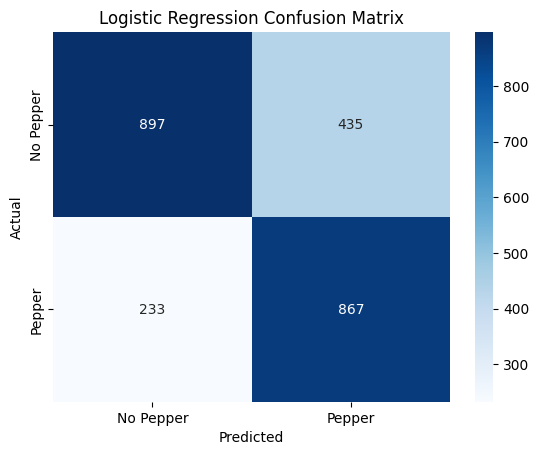

Logistic Regression AU(RO)C: 0.8080


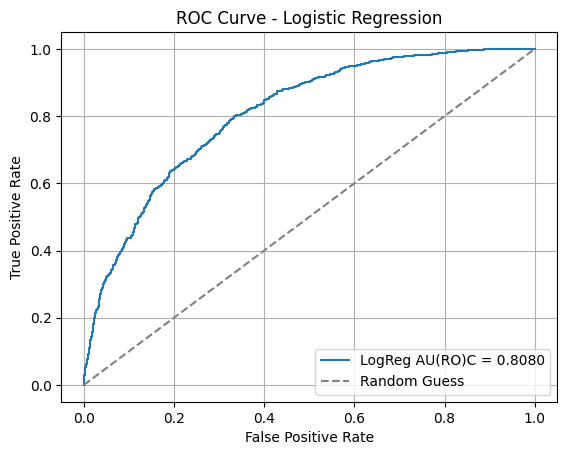

In [26]:
#10. 

df_for_classification = teacher_df.drop(columns = ["Major",
    "University",
    "US State"]).dropna()

# Split predictors and target
X = df_for_classification.drop(columns=["Received a Pepper?"])  # Predictors
y = df_for_classification["Received a Pepper?"]  # Target variable

# Generate a random state
random_state = rng.integers(0,N_number)

# Scale features to 0-1 range
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state= random_state
)

# Logistic Regression
log_reg = LogisticRegression(class_weight="balanced", random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
y_pred_log_reg = log_reg.predict(X_test)
y_prob_log_reg = log_reg.predict_proba(X_test)[:, 1]

# Logistic Regression Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

# Confusion Matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(conf_matrix_log_reg, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Pepper", "Pepper"], 
            yticklabels=["No Pepper", "Pepper"])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Logistic Regression AU(RO)C
log_reg_auc = roc_auc_score(y_test, y_prob_log_reg)
print(f"Logistic Regression AU(RO)C: {log_reg_auc:.4f}")

# Plot ROC Curve for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log_reg)
plt.plot(fpr_log, tpr_log, label=f'LogReg AU(RO)C = {log_reg_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid()
plt.show()

In [27]:
# Extra Credit
# Drop rows with missing data in "Number of Ratings"
teacher_df = teacher_df.dropna(subset=["Number of Ratings"])

# Separate the data into male and female groups
male_ratings = teacher_df[teacher_df["Male?"] == 1]["Number of Ratings"]
female_ratings = teacher_df[teacher_df["Female?"] == 1]["Number of Ratings"]

# If data is non-normal or ordinal, perform Mann-Whitney U test
u_stat, u_p_value = mannwhitneyu(male_ratings, female_ratings)
print(f"Mann-Whitney U-test results: U-statistic = {u_stat}, P-value = {u_p_value}")

Mann-Whitney U-test results: U-statistic = 412610851.0, P-value = 2.5511604939672565e-13
